In [107]:
import ast

import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Data cleaning

In [61]:
df = pd.read_csv("../data/responses_full.csv")

In [62]:
df['history'] = df['history'].apply(ast.literal_eval)
df['choices'] = df['choices'].apply(ast.literal_eval)

In [63]:
df = df.drop_duplicates(subset=["user_id"])

In [64]:
df["selection_count"] = df["history"].apply(len)

In [65]:
def process_choices(choices):
    chosen_headlines = []
    for _, v in choices.items():
        selected = v["selected"]
        options = v["options"]
        for hed, source in options.items():
            if hed == selected:
                chosen_headlines.append(source)
    
    return chosen_headlines

In [66]:
df["preference"] = df["choices"].apply(process_choices)

In [67]:
df["proportion_generated"] = df.preference.apply(lambda x: sum([1 for y in x if y == "Generated"]) / len(x))

# Statistical tests

In [55]:
def analyze_binary_choices(ai_selection_count, n_responses, alpha=0.05):
    """
    Analyze binary choice data.
    
    Parameters:
    -----------
    ai_selection_count : list or array
        Number of times the AI-generated headline was chosen for each question
    n_responses : int
        Total number of responses per question
    alpha : float, optional
        Significance level for statistical tests (default: 0.05)
        
    Returns:
    --------
    dict
        Dictionary containing analysis results
    """
    # Convert inputs to numpy arrays
    option_a_counts = np.array(ai_selection_count)
    n_questions = len(option_a_counts)
    total_trials = n_responses * n_questions
    
    # Pooled binomial test
    total_option_a = np.sum(option_a_counts)
    pooled_result = stats.binomtest(total_option_a, total_trials, p=0.5)
    
    # Calculate confidence interval for pooled proportion
    ci = pooled_result.proportion_ci()
    ci_lower, ci_upper = ci.low, ci.high

    # Chi-square test for homogeneity
    pooled_prop = total_option_a / total_trials
    expected = pooled_prop * n_responses
    chi2_stat = np.sum((option_a_counts - expected)**2 / expected + 
                      (n_responses - option_a_counts - (n_responses - expected))**2 / (n_responses - expected))
    chi2_p = stats.chi2.sf(chi2_stat, df=n_questions-1)
    
    # Individual binomial tests for each question
    individual_tests = []
    for i, count in enumerate(option_a_counts):
        result = stats.binomtest(count, n_responses, p=0.5)
        ci = result.proportion_ci()
        ci_lower, ci_upper = ci.low, ci.high
        individual_tests.append({
            'question': i + 1,
            'total_generated': count,
            'proportion': count / n_responses,
            'statistic': result.statistic,
            'p_value_corrected': result.pvalue * n_questions,
            'significant_corrected': result.pvalue * n_questions < alpha,
            'ci_lower': ci_lower,
            'ci_upper': ci_upper
        })
    
    # Compile results
    results = {
        'pooled_analysis': {
            'total_generated': total_option_a,
            'total_trials': total_trials,
            'pooled_proportion': pooled_prop,
            'statistic': pooled_result.statistic,
            'p_value': pooled_result.pvalue,
            'significant': pooled_result.pvalue < alpha,
            'confidence_interval': (ci_lower, ci_upper)
        },
        'heterogeneity_test': {
            'chi2_statistic': chi2_stat,
            'p_value': chi2_p,
            'df': n_questions - 1,
            'significant': chi2_p < alpha
        },
        'individual_tests': individual_tests
    }
    
    return results

def print_analysis(results):
    """
    Print formatted analysis results.
    
    Parameters:
    -----------
    results : dict
        Results dictionary from analyze_binary_choices
    """
    print("\nPOOLED ANALYSIS")
    print("===============")
    p = results['pooled_analysis']
    print(f"Total Generated selections: {p['total_generated']} out of {p['total_trials']}")
    print(f"Pooled proportion: {p['pooled_proportion']:.1%}")
    print(f"P-value: {p['p_value']}")
    print(f"Statistically significant: {p['significant']}")
    print(f"95% CI: ({p['confidence_interval'][0]:.1%} to {p['confidence_interval'][1]:.1%})")
    
    print("\nHETEROGENEITY TEST")
    print("==================")
    h = results['heterogeneity_test']
    print(f"Chi-square statistic: {h['chi2_statistic']:.3f} (df={h['df']})")
    print(f"P-value: {h['p_value']:.6f}")
    print(f"Questions significantly different: {h['significant']}")
    
    print("\nINDIVIDUAL QUESTIONS")
    print("===================")
    for test in results['individual_tests']:
        print(f"\nQuestion {test['question']}:")
        print(f"Generated selections: {test['total_generated']}")
        print(f"Proportion: {test['proportion']:.1%}")
        print(f"P-value (corrected): {test['p_value_corrected']:.6f}")
        print(f"Significant: {test['significant_corrected']}")

In [56]:
df["count_generated"] = df.preference.apply(lambda x: sum([1 for y in x if y == "Generated"]))

In [57]:
prefs = df.preference

question_gen_counts = []
for i in range(len(prefs[0])):
    question_gen_counts.append(sum([1 for x in prefs if x[i] == "Generated"]))

In [58]:
res = analyze_binary_choices(question_gen_counts, len(prefs))

In [59]:
print_analysis(res)


POOLED ANALYSIS
Total Generated selections: 311 out of 500
Pooled proportion: 62.2%
P-value: 5.407956956026173e-08
Statistically significant: True
95% CI: (55.8% to 75.2%)

HETEROGENEITY TEST
Chi-square statistic: 8.455 (df=4)
P-value: 0.076251
Questions significantly different: False

INDIVIDUAL QUESTIONS

Question 1:
Generated selections: 51
Proportion: 51.0%
P-value (corrected): 4.602054
Significant: False

Question 2:
Generated selections: 60
Proportion: 60.0%
P-value (corrected): 0.284440
Significant: False

Question 3:
Generated selections: 69
Proportion: 69.0%
P-value (corrected): 0.000916
Significant: True

Question 4:
Generated selections: 65
Proportion: 65.0%
P-value (corrected): 0.017588
Significant: True

Question 5:
Generated selections: 66
Proportion: 66.0%
P-value (corrected): 0.008950
Significant: True


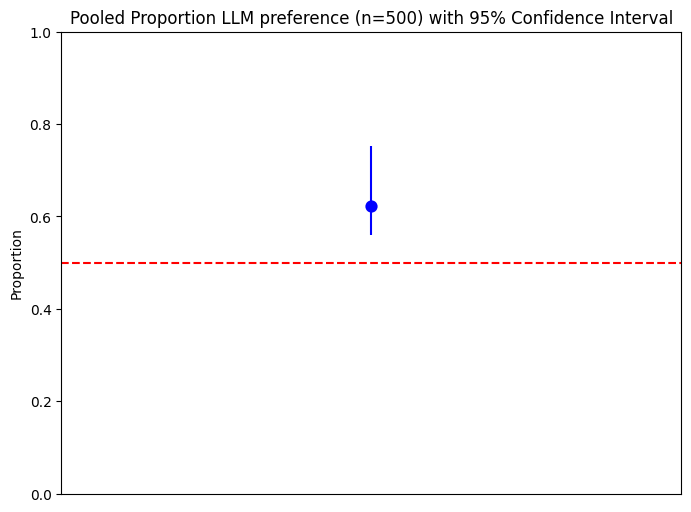

In [49]:
# Extract data from the pooled analysis
pooled_proportion = res['pooled_analysis']['statistic']
ci_lower, ci_upper = res['pooled_analysis']['confidence_interval']

# Create a seaborn plot
plt.figure(figsize=(8, 6))
sns.pointplot(x=[0], y=[pooled_proportion], capsize=0.2, color='blue')
plt.errorbar(x=[0], y=[pooled_proportion], yerr=[[pooled_proportion - ci_lower], [ci_upper - pooled_proportion]], fmt='o', color='blue')

# Add a horizontal line at 0.5
plt.axhline(y=0.5, color='red', linestyle='--')

# Customize the plot
plt.title('Pooled Proportion LLM preference (n=500) with 95% Confidence Interval')
plt.ylabel('Proportion')
plt.xticks([])  # Remove x-axis ticks
plt.ylim(0, 1)  # Set y-axis limits

# Show the plot
plt.show()

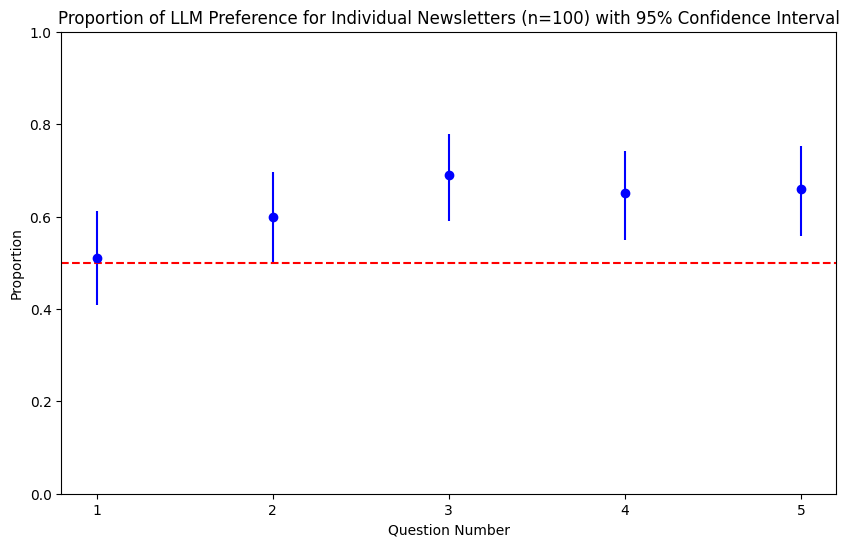

In [54]:
# Extract data for individual questions
individual_tests = res['individual_tests']
question_numbers = [test['question'] for test in individual_tests]
proportions = [test['proportion'] for test in individual_tests]
ci_lowers = [test['ci_lower'] for test in individual_tests]
ci_uppers = [test['ci_upper'] for test in individual_tests]

# Create a seaborn plot for individual questions
plt.figure(figsize=(10, 6))
yerr_lower = [p - l for p, l in zip(proportions, ci_lowers)]
yerr_upper = [u - p for p, u in zip(proportions, ci_uppers)]
plt.errorbar(x=question_numbers, y=proportions, yerr=[yerr_lower, yerr_upper], fmt='o', color='blue')

# Add a horizontal line at 0.5
plt.axhline(y=0.5, color='red', linestyle='--')

# Customize the plot
plt.title('Proportion of LLM Preference for Individual Newsletters (n=100) with 95% Confidence Interval')
plt.xlabel('Question Number')
plt.ylabel('Proportion')
plt.ylim(0, 1)  # Set y-axis limits
plt.xticks(ticks=question_numbers)  # Set x-axis to discrete values

# Show the plot
plt.show()

# Robustness/followups

## Preference variation - what does the distribution across respondents look like?

In [70]:
df.proportion_generated.describe()

count    100.000000
mean       0.622000
std        0.218156
min        0.200000
25%        0.400000
50%        0.600000
75%        0.800000
max        1.000000
Name: proportion_generated, dtype: float64

In [75]:
counts = df.groupby("proportion_generated").count()
counts = counts.user_id.reset_index()

In [77]:
counts[counts.proportion_generated > 0.5].user_id.sum() / counts.user_id.sum()

np.float64(0.71)

## Reading history - is there a relationship between the number of stories a participant selected and their preference?

In [80]:
df[["selection_count", "proportion_generated"]].corr(method="spearman")

,selection_count,proportion_generated
selection_count,1.000000,-0.040986
proportion_generated,-0.040986,1.000000


## Demographics

In [92]:
def process_demographics(path):
    df = pd.read_csv(path)
    df = df[df["Status"] == "APPROVED"]
    df = df[["Participant id", "Time taken", "Age", "Sex", "Ethnicity simplified", "Student status", "Employment status"]]
    df = df.rename(columns={"Participant id": "user_id"})
    df["Age"] = df["Age"].astype(int)
    df = df.drop_duplicates(subset=["user_id"])
    return df

In [93]:
demo_gated = process_demographics("../data/demographics_gated.csv")
demo_ungated = process_demographics("../data/demographics_ungated.csv")
demo = pd.concat([demo_gated, demo_ungated])

### Descriptives

<Axes: xlabel='Age', ylabel='Density'>

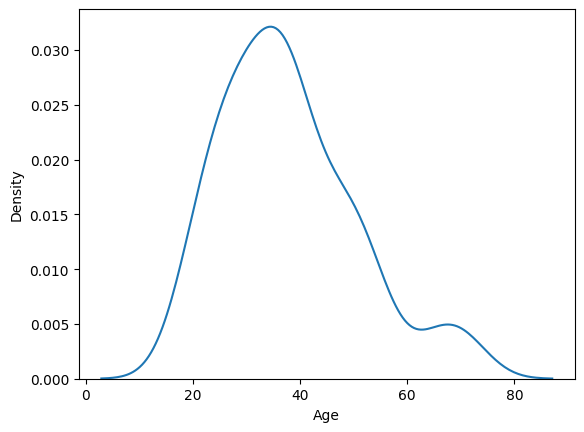

In [94]:
sns.kdeplot(demo["Age"])

In [95]:
demo["Age"].describe()

count    100.000000
mean      37.880000
std       12.607742
min       18.000000
25%       28.750000
50%       36.500000
75%       46.000000
max       72.000000
Name: Age, dtype: float64

In [97]:
demo["Sex"].value_counts()

Sex
Female    53
Male      47
Name: count, dtype: int64

In [99]:
demo["Ethnicity simplified"].value_counts()

Ethnicity simplified
White           60
Black           19
Asian            9
Mixed            7
Other            3
DATA_EXPIRED     2
Name: count, dtype: int64

In [101]:
demo["Student status"].value_counts()

Student status
No              66
Yes             23
DATA_EXPIRED    11
Name: count, dtype: int64

In [102]:
demo["Employment status"].value_counts()

Employment status
Full-Time                                                   54
Part-Time                                                   13
DATA_EXPIRED                                                12
Not in paid work (e.g. homemaker', 'retired or disabled)     7
Other                                                        6
Unemployed (and job seeking)                                 6
Due to start a new job within the next month                 2
Name: count, dtype: int64

### Regression analysis

In [155]:
responses_with_demographics = df.join(demo.set_index("user_id"), on="user_id")

In [156]:
responses_filtered = responses_with_demographics[~responses_with_demographics.isin(["DATA_EXPIRED"]).any(axis=1)]

In [157]:
X = pd.get_dummies(responses_filtered[['Sex', 'Ethnicity simplified', 'Student status', 'Employment status']], drop_first=True)

In [158]:
X["Age"] = responses_filtered["Age"]

In [159]:
X = sm.add_constant(X)

In [160]:
X = X.astype(float)

In [161]:
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.dropna().values, i) for i in range(X.shape[1])]
vif_data

,feature,VIF
0,const,61.274106
1,Sex_Male,1.197934
2,Ethnicity simplified_Black,2.744347
3,Ethnicity simplified_Mixed,1.902920
4,Ethnicity simplified_Other,1.318049
5,Ethnicity simplified_White,3.504400
6,Student status_Yes,1.219040
7,Employment status_Full-Time,11.698888
8,Employment status_Not in paid work (e.g. homem...,4.967039
9,Employment status_Other,4.168920


In [167]:
# Filter features where VIF is higher than 4
high_vif_features = vif_data[vif_data["VIF"] > 4]["feature"].tolist()

# Drop these features from X
X_filtered = X.drop(columns=high_vif_features)

X_filtered = X_filtered.rename(
    columns={
        "Sex_Male": "sex_male",
        "Ethnicity simplified_Black": "ethnicity_black",
        "Ethnicity simplified_Mixed": "ethnicity_mixed",
        "Ethnicity simplified_Other": "ethnicity_other",
        "Ethnicity simplified_White": "ethnicity_white",
        "Student status_Yes": "student",
        "Age": "age"
    }
)

X_filtered.head()

,sex_male,ethnicity_black,ethnicity_mixed,ethnicity_other,ethnicity_white,student,age
0,0.0,0.0,0.0,0.0,1.0,0.0,50.0
1,1.0,0.0,1.0,0.0,0.0,1.0,38.0
2,1.0,1.0,0.0,0.0,0.0,0.0,27.0
3,1.0,0.0,0.0,0.0,1.0,0.0,33.0
4,1.0,1.0,0.0,0.0,0.0,0.0,28.0


In [168]:
y = responses_filtered["proportion_generated"]

In [169]:
from statsmodels.formula.api import glm

import statsmodels.api as sm
import statsmodels.formula.api as smf

# Add a small constant to y to avoid issues with 0 or 1 values
y = y.clip(0.01, 0.99)

# Combine X_filtered and y into a single DataFrame for the regression
data = X_filtered.copy()
data['y'] = y

# Define the formula for the beta regression
formula = 'y ~ ' + ' + '.join(X_filtered.columns)

# Fit the beta regression model
model = smf.glm(formula=formula, data=data, family=sm.families.Binomial()).fit()

# Print the summary of the model
print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                   83
Model:                            GLM   Df Residuals:                       75
Model Family:                Binomial   Df Model:                            7
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -39.658
Date:                Fri, 06 Dec 2024   Deviance:                       17.881
Time:                        14:05:14   Pearson chi2:                     15.6
No. Iterations:                     4   Pseudo R-squ. (CS):           0.005998
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.3431      1.134     

# Time spent - relationship to preference?

In [172]:
responses_with_demographics[["selection_count", "Time taken", "proportion_generated"]].corr(method="spearman")

,selection_count,Time taken,proportion_generated
selection_count,1.000000,0.109821,-0.040986
Time taken,0.109821,1.000000,-0.088191
proportion_generated,-0.040986,-0.088191,1.000000
